
Engineering Features for each stock in the database. Using the option chain, the following script aims to extract critical information about the stock for that date. 
Each entry in the table has a Datetime index named 'gatherdate', and is in the format %Y-%m-%d %H:%M:%S sometimes it is %Y-%m-%dT%H:%M:%S.

The following features are derived from the option chain: 
1. `call_vol`: The total volume of call options traded for that day.
2. `put_vol`: The total volume of put options traded for that day.
3. `total_vol`: The total volume of options traded for that day.
4. `call_oi`: The total open interest of call options for that day.
5. `put_oi`: The total open interest of put options for that day.
6. `total_oi`: The total open interest of options for that day.
7. `call_prem`: The total premium of call options for that day.
8. `put_prem`: The total premium of put options for that day.
9. `total_prem`: The total premium of options for that day.
10. `call_iv`: The average implied volatility of call options for that day.
11. `put_iv`: The average implied volatility of put options for that day.
12. `atm_iv`: The average implied volatility of options that are at the money for that day.
13. `otm_iv`: The average implied volatility of options that are out of the money for that day.
14. `put_spread`: The average spread (ask - bid) of put options for that day.
15. `call_spread`: The average spread (ask - bid) of call options for that day.
16. `iv_rank`: The 52-week implied volatility rank for the stock. Values closer to 0 indicate cheap options, while values closer to 1 indicate expensive options.
17. `call_iv_rank`: The 52-week implied volatility rank for call options. 
18. `put_iv_rank`: The 52-week implied volatility rank for put options. 


In [1]:
import pandas as pd 
import numpy as np 
import sqlite3 as sql 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from trending import TrendAnalyzer
from volume import PeakDetector


import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import get_path
from bin.models.option_stats_model_setup import data
from bin.alerts.iterator import Iterator
from dataclasses import dataclass
from bin.plots.utils import human_format
from bin.plots.utils import pretty_print

class OptionDataModel(data):
    def __init__(self, connections):
        self.OptionsData = data(connections)
        self.iterator = Iterator(connections)
        self.daily_db = connections['daily_db']
    
    def get_option_data(self, stock):
        df = self.OptionsData._mdf(stock)
        self.features = ['total_vol', 'total_oi', 'Close', ]
        self.target = ['Close']
        return df

    def ohlcv(self, stock):
        df = self.OptionsData.price_data(stock)
        return df

    def get_aligned(self, stock): 
        # df = self.OptionsData.daily_opt_stat(stock)
        df = self.get_option_data(stock).set_index('date')
        pdf = self.ohlcv(stock).loc[df.index]
        return df, pdf 


connections = get_path('../../../')
data_conn = OptionDataModel(connections)

2025-04-27 20:07:30,915 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-04-27 20:07:30,915 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.


In [2]:
import sqlite3 as sql


conn = sql.connect(data_conn.OptionsData.vol_db)
df = pd.read_sql_query('SELECT * FROM spy', conn)

In [3]:
pretty_print(df.tail()[['gatherdate','total_vol', 'total_vol_chng', 'total_oi', 'total_oi_chng']])

,gatherdate,total_vol,total_vol_chng,total_oi,total_oi_chng
731,2025-04-23T14:06:20,"8,581,914.00","-363,539.00","16,691,279.00","75,506.00"
732,2025-04-24T10:12:40,"1,153,515.00","-7,428,399.00","17,160,436.00","469,157.00"
733,2025-04-24T13:36:32,"6,100,874.00","-2,481,040.00","17,160,436.00","469,157.00"
734,2025-04-25T11:52:54,"3,809,933.00","-2,290,941.00","14,518,483.00","-2,641,953.00"
735,2025-04-25T14:48:00,"7,687,668.00","1,586,794.00","14,518,483.00","-2,641,953.00"


In [5]:
from backtestingUtility import cp_backtesting_utility


cpb = cp_backtesting_utility(connections)

odf = cpb.build_cp_table('2025-04-25')
odf['pcr'] = odf['call_vol'] / odf['put_vol']
bodf = odf[odf['blowoff_vol'] == True].drop(columns = ['gatherdate'])
odf[['stock','call_vol','put_vol', 'total_vol']]

Daily Option Stats for 2025-04-25: 100%|██████████| 182/182 [00:03<00:00, 57.91it/s]


,stock,call_vol,put_vol,total_vol
1245,gdx,30973.0,72115,103088.0
1205,gme,148503.0,36181,184684.0
1242,amzn,353674.0,197859,551533.0
735,spy,3670549.0,4017119,7687668.0
1400,xlf,35190.0,182200,217390.0
...,...,...,...,...
69,oklo,17108.0,11297,28405.0
65,tem,26314.0,6166,32480.0
70,btu,9770.0,9207,18977.0
22,nke,109308.0,47413,156721.0


In [6]:
bodf[['stock','pcr']]

,stock,pcr


In [7]:
sodf = odf.sort_values('total_oi', ascending = False).head(10)[['stock','total_oi','total_oi_chng','call_oi','call_oi_chng','put_oi','put_oi_chng']]
pretty_print(sodf)

,stock,total_oi,total_oi_chng,call_oi,call_oi_chng,put_oi,put_oi_chng
1442,nvda,"18,745,215.00","-3,658,991.00","9,469,367.00","-1,984,176.00","9,275,848.00","-1,674,815.00"
735,spy,"14,518,483.00","-2,641,953.00","5,722,874.00","-976,187.00","8,795,609.00","-1,665,766.00"
1461,iwm,"9,090,184.00","-1,908,648.00","2,977,229.00","-593,421.00","6,112,955.00","-1,315,227.00"
1473,qqq,"7,994,277.00","-1,196,312.00","3,208,471.00","-525,088.00","4,785,806.00","-671,224.00"
1441,tsla,"7,194,113.00","-1,540,768.00","3,517,068.00","-869,341.00","3,677,045.00","-671,427.00"
1400,xlf,"4,996,599.00","-34,266.00","1,823,264.00","-26,352.00","3,173,335.00","-7,914.00"
1466,aapl,"4,637,925.00","-251,421.00","2,569,892.00","-174,418.00","2,068,033.00","-77,003.00"
1245,intc,"3,908,878.00","-1,653,340.00","2,337,600.00","-1,089,382.00","1,571,278.00","-563,958.00"
1439,slv,"3,377,275.00","-2,507,860.00","2,342,159.00","-1,802,810.00","1,035,116.00","-705,050.00"
1242,amzn,"3,330,706.00","-731,872.00","1,837,334.00","-357,043.00","1,493,372.00","-374,829.00"


In [8]:
def price_volume_oi_chart(df, pdf, fig, ax, stock = None):
    """
    Plot the price, volume, and open interest of a stock.
    Parameters:
    df (pd.DataFrame): Dataframe containing the options stats data.
    pdf (pd.DataFrame): Dataframe containing the price data.
    fig (matplotlib.figure.Figure): Figure object to plot on.
    ax (matplotlib.axes.Axes): Axes object to plot on.
    stock (str): Stock symbol.
    """
    


    # Align the dataframes
    pdf = pdf.loc[df.index]

    ax = ax.flatten()

    ax[0].plot(pdf.index, pdf.close, label = 'Close', color = 'blue')
    # Scatter plot high volume days
    high_option_vol_days = df[df.total_vol > df.total_vol.quantile(0.95)]
    high_option_vol_days = pdf.loc[high_option_vol_days.index]
    ax[0].scatter(high_option_vol_days.index, high_option_vol_days.close, color = 'red', label = 'High Option Volume', s = 20)

    # Scatter plot high volume days
    high_volume_days = pdf[pdf.volume > pdf.volume.quantile(0.95)]
    high_volume_days = pdf.loc[high_volume_days.index]
    ax[0].scatter(high_volume_days.index, high_volume_days.close, color = 'black', label = 'High Volume', s = 30, marker = '+')

    ax[0].legend()
    ax[1].plot(pdf.index, pdf.volume, color = 'green')

    ax[2].plot(df.index, df.total_vol, color = 'orange', alpha = 0.5)
    ax[2].plot(df.total_vol.rolling(20).mean(), color = 'orange', alpha = 0.9)
    ax[2].hlines(y =df.total_vol.quantile(0.95), xmin = df.index[0], xmax = df.index[-1], color = 'blue', linestyle = '--', label = '95% Quantile')
    
    ax[3].plot(df.index, df.total_oi, color = 'red', alpha = 0.5)
    ax[3].plot(df.total_oi.rolling(20).mean(), color = 'red', alpha = 0.9)
    ax[3].hlines(y =df.total_oi.quantile(0.95), xmin = df.index[0], xmax = df.index[-1], color = 'blue', linestyle = '--', label = '95% Quantile')


    if stock is None:
        stock = 'Close'
    titles = [f'${stock.upper()}', 'Volume', 'Options Volume', 'Open Interest']
    for i, title in enumerate(titles):
        if i > 0:
            yticks = ax[i].get_yticks()
            ytick_labels = [human_format(int(tick)) for tick in yticks]
            ax[i].set_yticklabels(ytick_labels)
        ax[i].set_title(title)
        ax[i].grid()

    fig.tight_layout()
    fig.autofmt_xdate(rotation = 0 )
    return ax


def show_plots(stock):
    df, pdf = data_conn.get_aligned(stock)
    # df = df["2024-10-01":"2025-12-31"]
    df = df.loc[df.index.drop_duplicates(keep = 'first')]
    pdf = pdf.loc[df.index]

    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    ax = price_volume_oi_chart(df, pdf, fig, ax, stock = stock)
    fig.tight_layout()
    fig.autofmt_xdate(rotation = 0 )
    fig.show()
    # fig.savefig(f'./{stock}_price_volume_oi_413.png', dpi = 300, bbox_inches = 'tight')
    return df, pdf


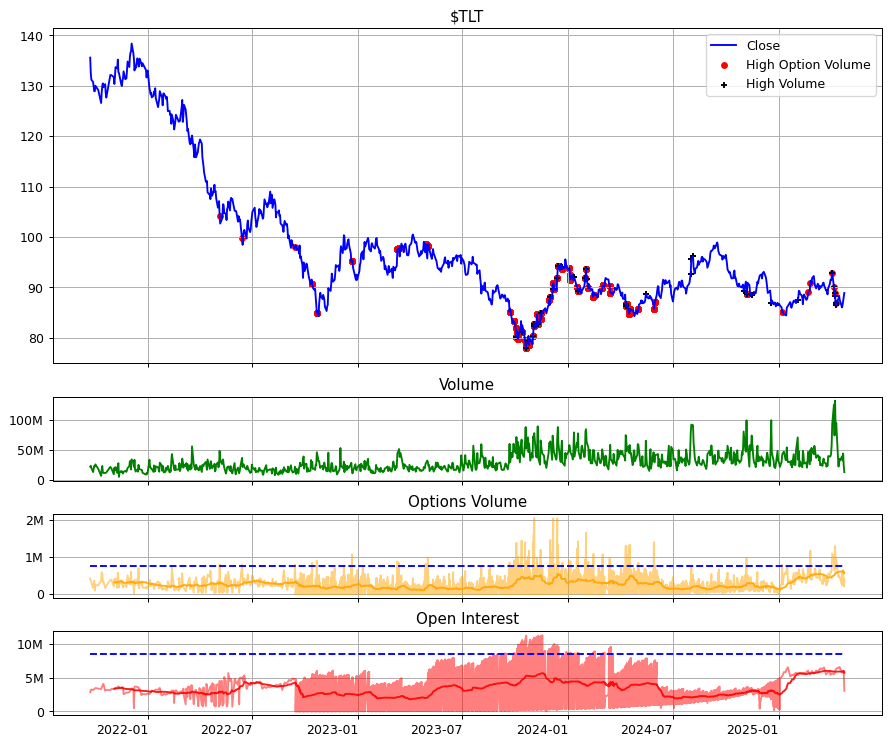

In [9]:
df, pdf = show_plots('tlt')

In [9]:
df["2023":]

,gatherdate,total_vol,total_prem,total_oi,call_vol,put_vol,call_oi,put_oi,call_iv,put_iv,...,pcr_rank,call_ivr,put_ivr,atm_ivr,otm_ivr,open,high,low,close,volume
date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,2023-01-03 14:37:20,606079,4.368657e+08,5666335,249710,356369,2883766,2782569,0.383233,0.291104,...,65.829068,14.175677,48.557772,32.516305,14.281297,14.838841,14.983723,14.084459,14.303280,401277000.0
2023-01-03,2023-01-03 14:37:20,3282,2.456206e+06,51474,545,2737,21124,30350,0.340612,0.227316,...,70.641462,6.131453,15.416806,28.023716,1.146485,14.838841,14.983723,14.084459,14.303280,401277000.0
2023-01-04,2023-01-04 10:43:21,310742,4.385328e+08,5766556,131440,179302,2932994,2833562,0.401762,0.266737,...,61.806528,15.873591,42.893811,40.395571,12.943097,14.555075,14.840840,14.229342,14.736925,431324000.0
2023-01-04,2023-01-04 10:43:21,2177,2.508391e+06,52229,1608,569,21332,30897,0.349093,0.225897,...,3.324192,6.415821,15.306722,42.614204,1.092722,14.555075,14.840840,14.229342,14.736925,431324000.0
2023-01-05,2023-01-05 11:47:49,732504,4.400195e+08,5889644,183912,548592,2970809,2918835,0.369118,0.317303,...,100.000000,12.882214,54.647551,36.434780,15.208696,14.479136,14.552077,14.136417,14.253322,389168000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,2025-04-17 14:48:58,4543764,1.217809e+09,23548006,2523191,2020573,12208963,11339043,0.416373,0.247890,...,20.800773,16.086213,65.951487,67.288804,25.529122,104.449997,104.470001,100.050003,101.489998,290833400.0
2025-04-21,2025-04-21 10:33:23,790620,1.171933e+09,21340246,398443,392177,10894537,10445709,0.650371,0.517010,...,28.788792,43.787555,100.000000,100.000000,22.269020,98.769997,99.440002,95.040001,96.910004,287197300.0
2025-04-21,2025-04-21 14:45:41,2480244,1.172913e+09,21340246,1427919,1052325,10894537,10445709,0.609415,0.541538,...,18.021468,38.939054,100.000000,98.142771,21.043362,98.769997,99.440002,95.040001,96.910004,287197300.0


df

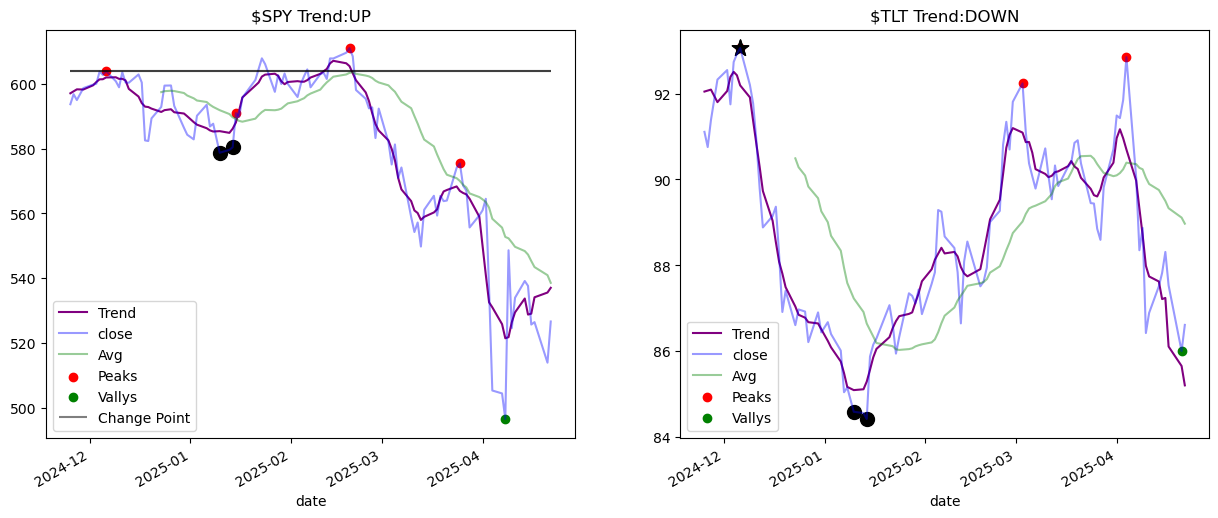

In [10]:
col = '_vol'; stock = 'wmt'
df = data_conn.get_option_data(stock)
x= df.call_oi.drop_duplicates().dropna()
y = df.put_oi.drop_duplicates().dropna()


stock1 = 'spy'; stock2 = 'tlt'
x = data_conn.price_data(stock1).close.tail(100)
y = data_conn.price_data(stock2).close.tail(100)


trends = []; peaks = []; vallys = []; 
change_points = []; change_points2 = []
for i in [x, y]:
    over, _, _ = TrendAnalyzer().analyze(i)
    p = PeakDetector(distance = 20).find_peaks(i.values)
    v = PeakDetector(distance = 20).find_valleys(i.values)
    cp = PeakDetector(distance = 20).find_trend_change_points(i.values)
    change_points.append(cp[0])
    change_points2.append(cp[1])
    peaks.append(i.iloc[p])
    vallys.append(i.iloc[v])
    trends.append(over)


fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.flatten()

TrendAnalyzer().decompose(x).trend.plot(ax=ax[0], label='Trend', color='purple')
TrendAnalyzer().decompose(y).trend.plot(ax=ax[1], label='Trend', color='purple')


x.plot(ax=ax[0], color='blue', alpha = 0.4)
x.rolling(window=20).mean().plot(ax=ax[0], label='Avg', color='green', alpha=0.4)
ax[0].scatter(peaks[0].index, peaks[0].values, color='red', label='Peaks')
ax[0].scatter(vallys[0].index, vallys[0].values, color='green', label='Vallys')

changepoint = x.iloc[change_points]
cp2 = x.iloc[change_points2]
# ax[0].scatter(changepoint.index, changepoint.values, color='black', marker = '*', s = 150)
# Use as a hline instead 
ax[0].hlines(y=changepoint.values, xmin=x.index[0], xmax=x.index[-1], color='black', alpha = 0.5, label = 'Change Point')
ax[0].scatter(cp2.index, cp2.values, color='black', marker = 'o', s = 100)

y.plot(ax=ax[1], color='blue', alpha = 0.4)
y.rolling(window=20).mean().plot(ax=ax[1], label='Avg', color='green', alpha=0.4)
ax[1].scatter(peaks[1].index, peaks[1].values, color='red', label='Peaks')
ax[1].scatter(vallys[1].index, vallys[1].values, color='green', label='Vallys')
changepoint = y.iloc[change_points]
cp2 = y.iloc[change_points2]
ax[1].scatter(changepoint.index, changepoint.values, color='black', marker = '*', s = 150)
ax[1].scatter(cp2.index, cp2.values, color='black', marker = 'o', s = 100)


ax[0].legend()
ax[1].legend()

ax[0].set_title('$'+stock1.upper() + ' Trend:' + trends[0].upper())
ax[1].set_title('$'+stock2.upper() + ' Trend:' + trends[1].upper())
plt.show()

In [11]:
change_points

[8, 8]

its very easy to find the trend, seasonality, and slope of the regression line for any of the variables we have. See the example below; ran on all stocks so that we can begin the filtering process to find the best trades. 

In [12]:
stocks = data_conn.OptionsData.stocks['all_stocks']
trend = TrendAnalyzer()

out = pd.DataFrame()

for stock in stocks:
    # x = data_conn.ohlcv(stock)['close']
    try:
        x = data_conn.get_option_data(stock).set_index('gatherdate')['total_vol'].dropna()
        x = x["2024":]
        # x = data_conn.price_data(stock)['close'].dropna()["2024":]
        trend_direction, seasonality, slope = trend.analyze(x)
        tmp = pd.DataFrame({
            'stock': [stock], 
            'id':[x.name],
            'trend': [trend_direction], 
            'seasonality': [seasonality], 
            'slope': [slope],
            
        })
        out = pd.concat([out, tmp])
    except Exception as e:
        print(e)



'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'
'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'
'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'
'Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.'


In [13]:
out.sort_values(by = 'slope', ascending = False)

,stock,id,trend,seasonality,slope
0,nvda,total_vol,down,normal,2172.787178
0,smci,total_vol,down,normal,496.882543
0,avgo,total_vol,down,low,275.066914
0,u,total_vol,down,normal,230.373405
0,btu,total_vol,up,high,190.261279
...,...,...,...,...,...
0,oklo,total_vol,down,normal,-1320.222162
0,tem,total_vol,down,normal,-1700.949354
0,amd,total_vol,down,low,-4228.716447
0,nke,total_vol,down,high,-13773.406050


In [14]:
out.slope.describe()

count      180.000000
mean      -348.035896
std       2763.530971
min     -34161.438717
25%        -87.744683
50%        -21.808307
75%         -3.770300
max       2172.787178
Name: slope, dtype: float64

In [15]:

out[
    (out.seasonality == 'high') &
    (out.trend == 'down') 
]

,stock,id,trend,seasonality,slope
0,spy,total_vol,down,high,-34161.438717
0,aal,total_vol,down,high,-109.116961
0,xlu,total_vol,down,high,-42.483628
0,mu,total_vol,down,high,-9.056621
0,mos,total_vol,down,high,-12.316396
0,xme,total_vol,down,high,-19.065081
0,xly,total_vol,down,high,-50.487237
0,xlp,total_vol,down,high,-22.059123
0,tlt,total_vol,down,high,19.750260
0,gsl,total_vol,down,high,-4.380297


In [16]:
out[out.stock == 'spy']

,stock,id,trend,seasonality,slope
0,spy,total_vol,down,high,-34161.438717
